## Setup

In [31]:
import sys
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append(str(Path.cwd().parent.parent))
from models.llm.common import METRICS_DIR, DATA_DIR
from evaluation.llm.helpers import (
    load_metric_files,
    to_llm_score_data,
    extract_model_metrics,
    plot_model_metrics_combined_scatter,
    build_prompt_configuration_table,
    compute_optimization_comparison_table,
    compute_scale_comparison_table,
)
from evaluation.llm.interface import (
    llm_metrics_to_core,
    get_llm_model_groups,
    to_int_0_5,
)
from evaluation.core import (
    vis_all_models_plots,
    vis_all_models_tables,
    vis_specific_model_conf_matrices,
    format_metrics_for_latex,
    load_train_test_data,
)

sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (14, 8)

In [32]:
metric_files = sorted(METRICS_DIR.glob("*.json"))
print(f"Found {len(metric_files)} metric files:")
for f in metric_files:
    print(f"  - {f.name}")

all_metrics = []

for metric_file in metric_files:
    try:
        model_metrics = extract_model_metrics(metric_file)
        all_metrics.extend(model_metrics)
        print(f"✓ Processed {metric_file.name}: {len(model_metrics)} models")
    except Exception as e:
        print(f"✗ Error processing {metric_file.name}: {e}")

df_metrics = pd.DataFrame(all_metrics)
print(f"\nTotal metrics extracted: {len(df_metrics)}")
print(f"\nUnique prompts: {df_metrics['prompt'].nunique()}")
print(f"Unique models: {df_metrics['model_name'].nunique()}")

print("\nMetrics Summary Statistics:")
print(
    df_metrics[
        ["throughput", "error_rate", "correlation", "rmse", "accuracy"]
    ].describe()
)

Found 14 metric files:
  - few-shot-cot_cot_Rate-each-_2026-01-24-12-40-23.json
  - few-shot-cot_cot_Rate-this-_2026-01-24-12-09-15.json
  - few-shot_cot_On-a-scale_2026-01-24-11-39-23.json
  - few-shot_cot_Rate-each-_2026-01-24-12-30-06.json
  - few-shot_cot_Rate-this-_2026-01-24-11-59-16.json
  - few-shot_no-cot_On-a-scale_2026-01-24-11-38-34.json
  - few-shot_no-cot_Rate-each-_2026-01-24-12-29-10.json
  - few-shot_no-cot_Rate-this-_2026-01-24-11-58-26.json
  - zero-shot_cot_On-a-scale_2026-01-24-11-30-07.json
  - zero-shot_cot_Rate-each-_2026-01-24-12-18-55.json
  - zero-shot_cot_Rate-this-_2026-01-24-11-48-40.json
  - zero-shot_no-cot_On-a-scale_2026-01-24-11-29-10.json
  - zero-shot_no-cot_Rate-each-_2026-01-24-12-17-41.json
  - zero-shot_no-cot_Rate-this-_2026-01-24-11-47-49.json
✓ Processed few-shot-cot_cot_Rate-each-_2026-01-24-12-40-23.json: 1 models
✓ Processed few-shot-cot_cot_Rate-this-_2026-01-24-12-09-15.json: 1 models
✓ Processed few-shot_cot_On-a-scale_2026-01-24-11-39-

## Model Selection

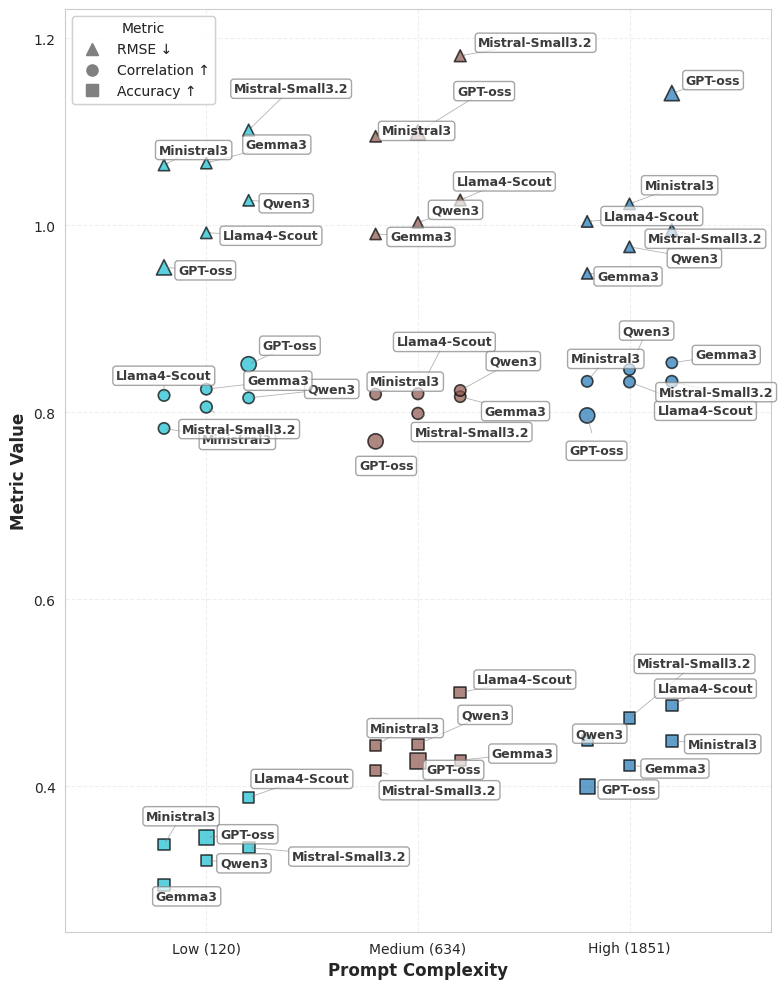

In [30]:
# plot_model_metrics_scatter(
#     df=df_metrics,
#     metric_column="correlation",
#     ylabel="Correlation",
#     min_threshold=0.1,
#     y_padding=0.05,
#     figsize=(6, 8),
#     shorten_model_names=False,
# )
# plot_model_metrics_scatter(
#     df=df_metrics,
#     metric_column="rmse",
#     ylabel="RMSE",
#     min_threshold=0.1,
#     y_padding=0.025,
#     figsize=(6, 8),
#     shorten_model_names=True,
# )
# plot_model_metrics_scatter(
#     df=df_metrics,
#     metric_column="accuracy",
#     ylabel="Accuracy",
#     min_threshold=0.1,
#     y_padding=0.025,
#     figsize=(6, 8),
#     shorten_model_names=True,
# )

plot_model_metrics_combined_scatter(
    df=df_metrics,
    min_threshold=0.1,
    y_padding=0.05,
    figsize=(8, 10),
    shorten_model_names=True,
    show_labels=True,
)

### Model Summary

In [ ]:
summary_table = df_metrics.pivot_table(
    index="model_name",
    columns="prompt",
    values=["correlation", "rmse", "accuracy", "throughput", "error_rate"],
    aggfunc="first",
)

print("Correlation Summary:")
print("=" * 80)
print(summary_table["correlation"].round(3))

print("\n\nRMSE Summary:")
print("=" * 80)
print(summary_table["rmse"].round(3))

print("\n\nAccuracy Summary:")
print("=" * 80)
print(summary_table["accuracy"].round(3))

print("\n\nThroughput Summary (predictions/sec):")
print("=" * 80)
print(summary_table["throughput"].round(3))

print("\n\nError Rate Summary (%):")
print("=" * 80)
print(summary_table["error_rate"].round(1))

Correlation Summary:
prompt                On a scale of 0-5, rate how well this text allows a reader to visualize the scene, objects, or characters described: 0=not visualizable, 1=simple object/person, 2=recognizable place/basic character, 3=basic scene/detailed face, 4=full scene with details, 5=vivid complete scene.\n\n## Examples\nHere are examples demonstrating each rating level:\n\n<example>\n<text_segment>If not, please say so. The alternative is in the hands of the Crown. I am the Crown. The Crown may at any time confiscate property and banish malcontents and disturbers.</text_segment>\n<rating>0</rating>\n</example>\n\n<example>\n<text_segment>By this time the fresh new fool's cap made from yesterday's "Bee" would have been pinned on her head. "Quelle injustice! Quelle injustice!" This last apostrophe in a high, whining nasal voice, always procured Pupasse's elevation on the tall three-legged stool in the corner.</text_segment>\n<rating>1</rating>\n</example>\n\n<example>\n<t

### Overall Model Ranking

In [33]:
overall_ranking = (
    df_metrics.groupby("model_name")
    .agg(
        {
            "correlation": "mean",
            "rmse": "mean",
            "accuracy": "mean",
            "throughput": "mean",
            "error_rate": "mean",
        }
    )
    .round(3)
    .sort_values("correlation", ascending=False)
)

print("\nOverall Model Rankings (Average across all prompts):")
print("=" * 80)
print(overall_ranking)


Overall Model Rankings (Average across all prompts):
                  correlation  rmse  accuracy  throughput  error_rate
model_name                                                           
Llama4-Scout-17b        0.826  1.01     0.475      11.822         0.0


## Prompt Table

In [38]:
df_table = build_prompt_configuration_table(df_metrics)

# Generate LaTeX table
latex_table = df_table.to_latex(
    index=False,
    escape=False,
    caption="Prompt Configuration Evaluation Results",
    label="tab:prompt_configs",
)
print(latex_table)

# Also display as formatted table for quick review
print("\n\nFormatted Table:")
print(df_table.to_string(index=False))

\begin{table}
\caption{Prompt Configuration Evaluation Results}
\label{tab:prompt_configs}
\begin{tabular}{rllllll}
\toprule
\textbf{#} & Task Descr. & \textbf{Examples} & \textbf{CoT} & \textbf{CORR} & \textbf{RMSE} & \textbf{ACC} \\
\midrule
1 & Short &  &  & 0.827 & 0.973 & 0.395 \\
2 & Short &  & zero-shot & 0.815 & 1.003 & 0.364 \\
3 & Short & yes &  & 0.836 & \textbf{0.956} & 0.491 \\
4 & Short & yes & zero-shot & 0.822 & 0.983 & 0.478 \\
5 & Expanded &  &  & 0.833 & 1.045 & 0.492 \\
6 & Expanded &  & zero-shot & 0.795 & 1.142 & 0.457 \\
7 & Expanded & yes &  & \textbf{0.849} & 0.977 & 0.512 \\
8 & Expanded & yes & zero-shot & 0.823 & 1.017 & 0.503 \\
9 & Expanded & yes & few-shot & 0.827 & 0.994 & 0.471 \\
10 & Full &  &  & 0.821 & 1.028 & 0.492 \\
11 & Full &  & zero-shot & 0.804 & 1.059 & 0.459 \\
12 & Full & yes &  & 0.845 & 0.990 & \textbf{0.533} \\
13 & Full & yes & zero-shot & 0.835 & 0.985 & 0.522 \\
14 & Full & yes & few-shot & 0.836 & 0.992 & 0.486 \\
\bottomrule
\end{t

## Load Configs

In [57]:
# Load all metric files
metric_files = sorted(METRICS_DIR.glob("*.json"))
items = load_metric_files(metric_files)

config_names = [item.get("prompt_id", f"config_{i}") for i, item in enumerate(items)]

print(f"Available configurations ({len(config_names)}):")
for idx, name in enumerate(config_names):
    print(f"  {idx}: {name}")

Available configurations (14):
  0: few-shot-cot_cot_action_Rate-each-
  1: few-shot-cot_cot_no-action_Rate-this-
  2: few-shot_cot_action_Rate-each-
  3: few-shot_cot_no-action_On-a-scale
  4: few-shot_cot_no-action_Rate-this-
  5: few-shot_no-cot_action_Rate-each-
  6: few-shot_no-cot_no-action_On-a-scale
  7: few-shot_no-cot_no-action_Rate-this-
  8: zero-shot_cot_action_Rate-each-
  9: zero-shot_cot_no-action_On-a-scale
  10: zero-shot_cot_no-action_Rate-this-
  11: zero-shot_no-cot_action_Rate-each-
  12: zero-shot_no-cot_no-action_On-a-scale
  13: zero-shot_no-cot_no-action_Rate-this-


## Metrics vs Prompt Token Count

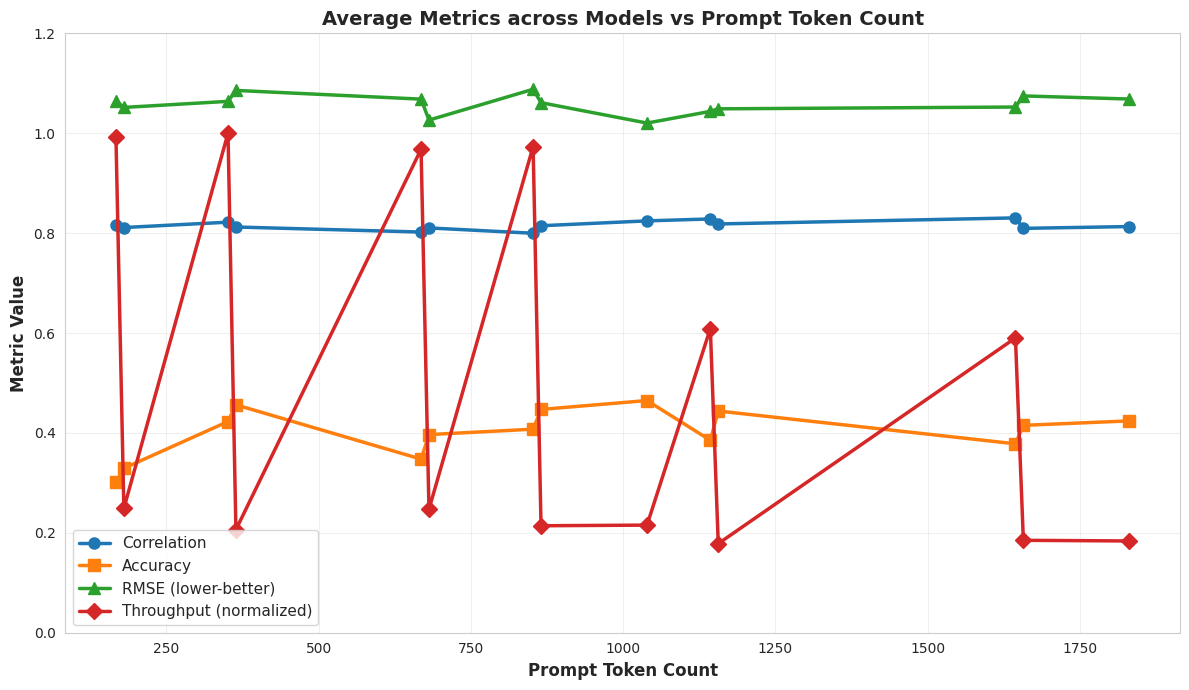


Metrics by Prompt Token Count:
 prompt_token_count  correlation  rmse  accuracy  throughput
                167        0.816 1.065     0.302      11.682
                180        0.811 1.052     0.329       2.929
                351        0.822 1.064     0.423      11.770
                364        0.812 1.086     0.456       2.428
                668        0.802 1.068     0.348      11.391
                681        0.810 1.026     0.397       2.909
                852        0.800 1.088     0.408      11.455
                865        0.815 1.061     0.447       2.521
               1039        0.825 1.020     0.465       2.536
               1143        0.828 1.044     0.385       7.167
               1156        0.818 1.049     0.444       2.100
               1644        0.830 1.052     0.378       6.947
               1657        0.810 1.075     0.415       2.178
               1831        0.813 1.068     0.424       2.162


In [ ]:
# Create mapping from items (items have the actual token counts)
prompt_to_token_count = {}
for item in items:
    prompt_id = item.get("prompt_id", "unknown")
    prompt_token_count = item.get("prompt_token_count", None)
    if prompt_id and prompt_token_count is not None:
        prompt_to_token_count[prompt_id] = int(prompt_token_count)


# Match df_metrics prompt_ids with items prompt_ids using prefix matching
def find_token_count(df_id):
    for item_id, token_count in prompt_to_token_count.items():
        if df_id.startswith(item_id):
            return token_count
    return None


df_metrics["prompt_token_count"] = df_metrics["prompt_id"].apply(find_token_count)

# Group by prompt_token_count and calculate mean metrics
df_grouped = (
    df_metrics.dropna(subset=["prompt_token_count"])
    .groupby("prompt_token_count")[["correlation", "rmse", "accuracy", "throughput"]]
    .mean()
    .reset_index()
)

# Sort by prompt_token_count
df_grouped = df_grouped.sort_values("prompt_token_count")

fig, ax = plt.subplots(figsize=(12, 7))

ax.plot(
    df_grouped["prompt_token_count"],
    df_grouped["correlation"],
    marker="o",
    linewidth=2.5,
    label="Correlation",
    markersize=8,
)
ax.plot(
    df_grouped["prompt_token_count"],
    df_grouped["accuracy"],
    marker="s",
    linewidth=2.5,
    label="Accuracy",
    markersize=8,
)
ax.plot(
    df_grouped["prompt_token_count"],
    df_grouped["rmse"],
    marker="^",
    linewidth=2.5,
    label="RMSE (lower-better)",
    markersize=8,
)

if df_grouped["throughput"].max() > 0:
    throughput_normalized = df_grouped["throughput"] / df_grouped["throughput"].max()
    ax.plot(
        df_grouped["prompt_token_count"],
        throughput_normalized,
        marker="D",
        linewidth=2.5,
        label="Throughput (normalized)",
        markersize=8,
    )

ax.set_xlabel("Prompt Token Count", fontsize=12, fontweight="bold")
ax.set_ylabel("Metric Value", fontsize=12, fontweight="bold")
ax.set_title(
    "Average Metrics across Models vs Prompt Token Count",
    fontsize=14,
    fontweight="bold",
)
ax.legend(fontsize=11, loc="best")
ax.grid(True, alpha=0.3)
ax.set_ylim(0, 1.2)

plt.tight_layout()
plt.show()

print("\nMetrics by Prompt Token Count:")
print(df_grouped.round(3).to_string(index=False))

## Post-optimization Table

In [68]:
import re

SELECTED_CONFIG_IDX = 1
SELECTED_MODEL_NAME = "Mistral-Small3.2-24b"

PRE_OPTIMIZATION_DIR = METRICS_DIR / "pre-optimization"

# Load pre-optimization metrics
pre_optim_metric_files = sorted(PRE_OPTIMIZATION_DIR.glob("*.json"))
print(f"Found {len(pre_optim_metric_files)} pre-optimization metric files")

pre_optim_metrics = []
for metric_file in pre_optim_metric_files:
    try:
        model_metrics = extract_model_metrics(metric_file)
        pre_optim_metrics.extend(model_metrics)
    except Exception as e:
        print(f"✗ Error processing {metric_file.name}: {e}")

df_pre_optim = pd.DataFrame(pre_optim_metrics)

# Compute comparison table
df_comparison_table = compute_optimization_comparison_table(
    df_current=df_metrics,
    df_pre_optim=df_pre_optim,
    selected_config_idx=SELECTED_CONFIG_IDX,
    config_names=config_names,
    selected_model_name=SELECTED_MODEL_NAME,
)

print(
    f"\nOptimization Comparison for Config {SELECTED_CONFIG_IDX}: {config_names[SELECTED_CONFIG_IDX]}"
)
print("=" * 100)
print(df_comparison_table.round(4).to_string(index=False))

# Bold headers, keep rows unbolded
header_bold_table = df_comparison_table.rename(columns=lambda col: f"\\textbf{{{col}}}")
latex_table = header_bold_table.to_latex(index=False, escape=False, bold_rows=False)

# Color the deltas based on their sign
latex_table = re.sub(
    r"([+-]?\d*\.\d+)", r"\\textcolor{red}{\\textbf{\\text{\1}}}", latex_table
)
latex_table = re.sub(
    r"([+-]?\d+)", r"\\textcolor{green}{\\textbf{\\text{\1}}}", latex_table
)

# Display the LaTeX table
print(latex_table)

Found 14 pre-optimization metric files

Optimization Comparison for Config 1: few-shot-cot_cot_no-action_Rate-this-
               Model   CORR  Δ CORR   RMSE  Δ RMSE    ACC  Δ ACC
Mistral-Small3.2-24b 0.8285     0.0 1.0127     0.0 0.4923    0.0
       Avg-of-Others 0.8232     0.0 1.0229     0.0 0.4557    0.0
\begin{tabular}{lrrrrrr}
\toprule
\textbf{Model} & \textbf{CORR} & \textbf{Δ CORR} & \textbf{RMSE} & \textbf{Δ RMSE} & \textbf{ACC} & \textbf{Δ ACC} \\
\midrule
Mistral-Small\textcolor{red}{\textbf{\text{\textcolor{green}{\textbf{\text{3}}}.\textcolor{green}{\textbf{\text{2}}}}}}\textcolor{green}{\textbf{\text{-24}}}b & \textcolor{red}{\textbf{\text{\textcolor{green}{\textbf{\text{0}}}.\textcolor{green}{\textbf{\text{828473}}}}}} & \textcolor{red}{\textbf{\text{\textcolor{green}{\textbf{\text{0}}}.\textcolor{green}{\textbf{\text{000000}}}}}} & \textcolor{red}{\textbf{\text{\textcolor{green}{\textbf{\text{1}}}.\textcolor{green}{\textbf{\text{012675}}}}}} & \textcolor{red}{\textbf{\

## Model Evaluation with Core Visualization

In [53]:
SELECTED_CONFIG_IDX = 1
SELECTED_MODEL_NAME = "Mistral-Small3.2-24b"
print(f"Selected configuration: {config_names[SELECTED_CONFIG_IDX]}")

df_train, df_test = load_train_test_data(DATA_DIR)
score_data = to_llm_score_data(items, df_train, df_test)
filtered_score_data = [sd for sd in score_data if sd.config_id == SELECTED_CONFIG_IDX]
selected_model_data = next(
    (sd for sd in filtered_score_data if sd.model_name == SELECTED_MODEL_NAME),
    None,
)

available_models = [sd.model_name for sd in filtered_score_data]
print(f"Configuration: Config {SELECTED_CONFIG_IDX}")
print(f"Selected model: {SELECTED_MODEL_NAME}")
print(f"Available models: {available_models}")

multiple_models = []
for sd in filtered_score_data:
    train_outputs = (
        to_int_0_5(sd.train_scores)
        if sd.train_scores is not None and sd.train_scores.size > 0
        else None
    )
    test_outputs = (
        to_int_0_5(sd.test_scores)
        if sd.test_scores is not None and sd.test_scores.size > 0
        else None
    )

    if train_outputs is not None or test_outputs is not None:
        converted = llm_metrics_to_core(
            predictions=train_outputs,
            labels=sd.y_train if train_outputs is not None else None,
            test_predictions=test_outputs,
            test_labels=sd.y_test if test_outputs is not None else None,
            model_name=sd.model_name,
        )
        multiple_models.append(converted)

print(
    f"Loaded {len(multiple_models)} model(s) from configuration {SELECTED_CONFIG_IDX}"
)
for m in multiple_models:
    train_status = "✓" if m.train is not None else "✗"
    test_status = "✓" if m.test is not None else "✗"
    print(f"  - {m.model} [Train: {train_status}, Test: {test_status}]")

Selected configuration: few-shot-cot_cot_no-action_Rate-this-
Configuration: Config 1
Selected model: Mistral-Small3.2-24b
Available models: ['Ministral3-14b', 'Gemma3-12b', 'Qwen3-14b', 'Mistral-Small3.2-24b']
Loaded 4 model(s) from configuration 1
  - Ministral3-14b [Train: ✓, Test: ✗]
  - Gemma3-12b [Train: ✓, Test: ✗]
  - Qwen3-14b [Train: ✓, Test: ✗]
  - Mistral-Small3.2-24b [Train: ✓, Test: ✗]


/home/terra/Projects/vis-desc/modules/lab/src/evaluation/llm/interface.py:28: RuntimeWarning: invalid value encountered in cast
  return np.clip(np.round(values), 0, 5).astype(int)


### Confusion Matrices



TRAIN SET CONFUSION MATRIX


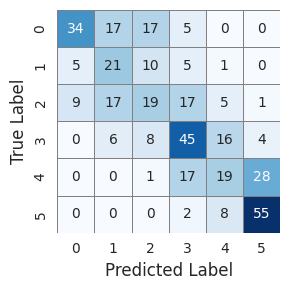


Confusion Matrix Statistics:
  Total predictions: 392
  Correct predictions (diagonal): 193
  Incorrect predictions (off-diagonal): 199
  Accuracy: 0.4923

Per-label statistics:
  Label 0: 34/73 correct (46.58%)
  Label 1: 21/42 correct (50.00%)
  Label 2: 19/68 correct (27.94%)
  Label 3: 45/79 correct (56.96%)
  Label 4: 19/65 correct (29.23%)
  Label 5: 55/65 correct (84.62%)


In [55]:
if selected_model_data is None:
    print(
        f"Selected model {SELECTED_MODEL_NAME} not found in configuration {SELECTED_CONFIG_IDX}"
    )
else:
    conf_model = llm_metrics_to_core(
        predictions=to_int_0_5(selected_model_data.train_scores)
        if selected_model_data.train_scores is not None
        and selected_model_data.train_scores.size > 0
        else None,
        labels=selected_model_data.y_train
        if selected_model_data.train_scores is not None
        and selected_model_data.train_scores.size > 0
        else None,
        test_predictions=to_int_0_5(selected_model_data.test_scores)
        if selected_model_data.test_scores is not None
        and selected_model_data.test_scores.size > 0
        else None,
        test_labels=selected_model_data.y_test
        if selected_model_data.test_scores is not None
        and selected_model_data.test_scores.size > 0
        else None,
        model_name=selected_model_data.model_name,
    )
    vis_specific_model_conf_matrices(
        conf_model, show_proportional=False, show_title=False
    )

### Multiple Models Comparison


#### Per-label metrics and model comparison plots

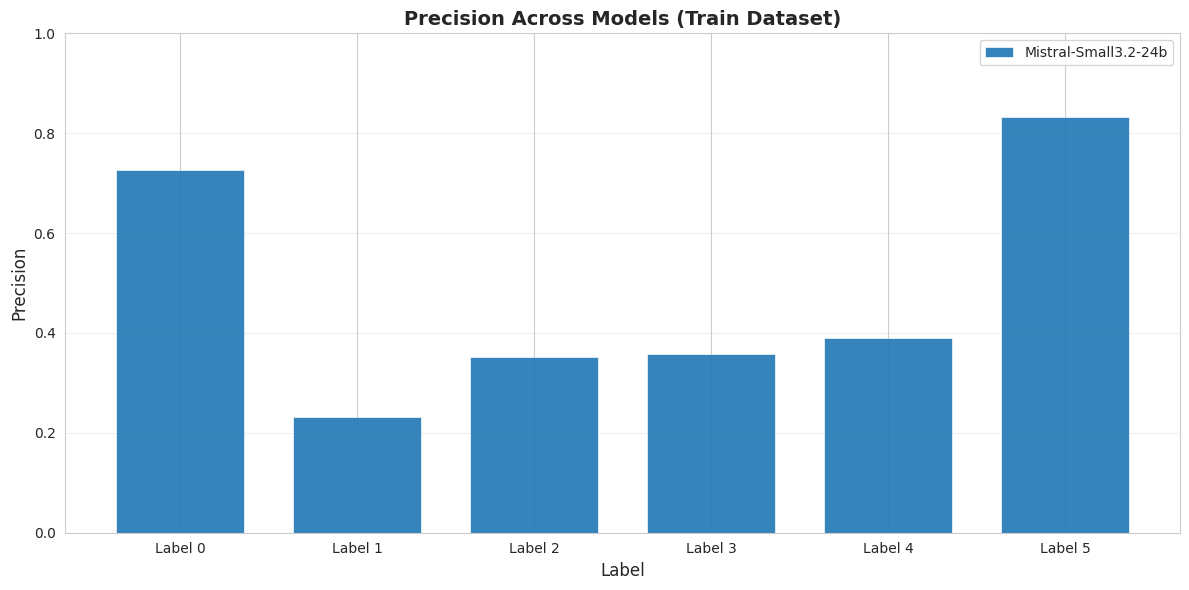

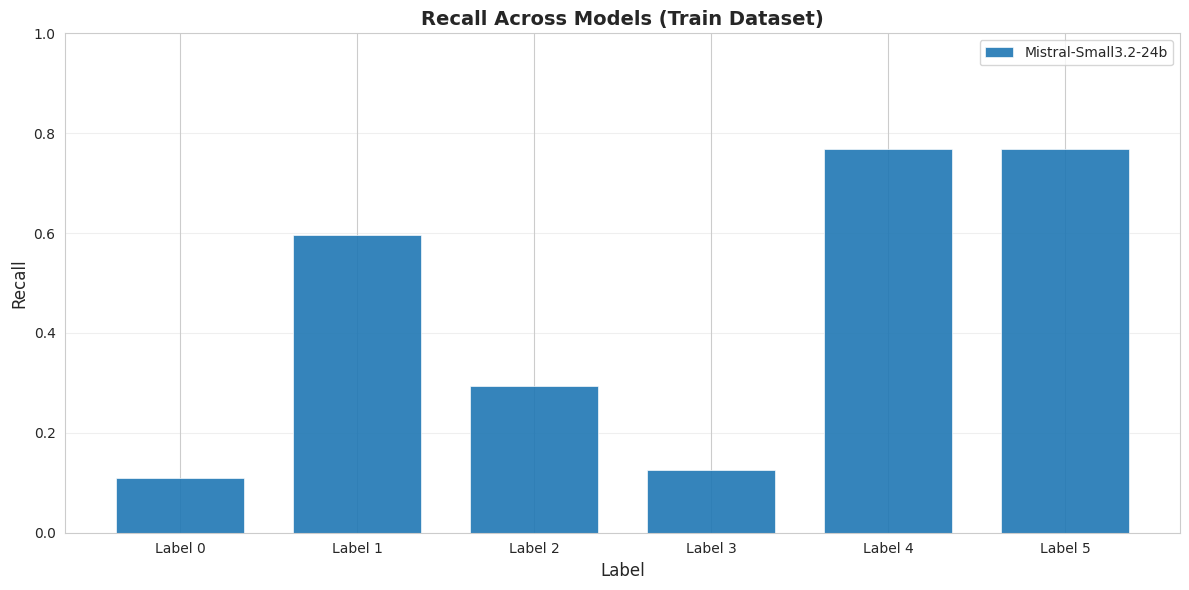

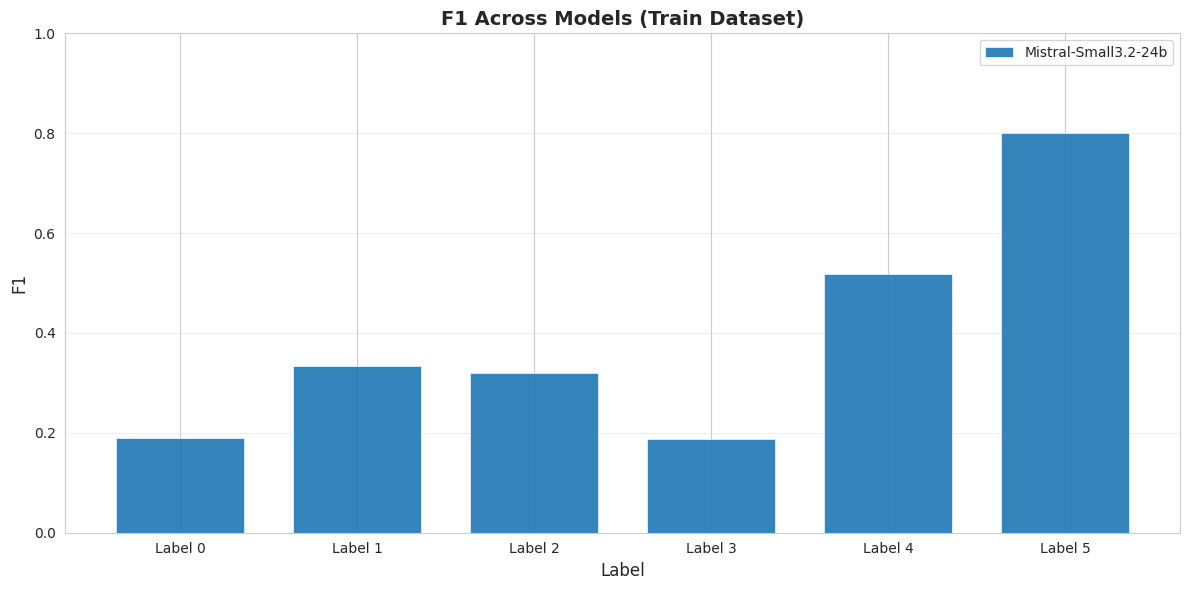

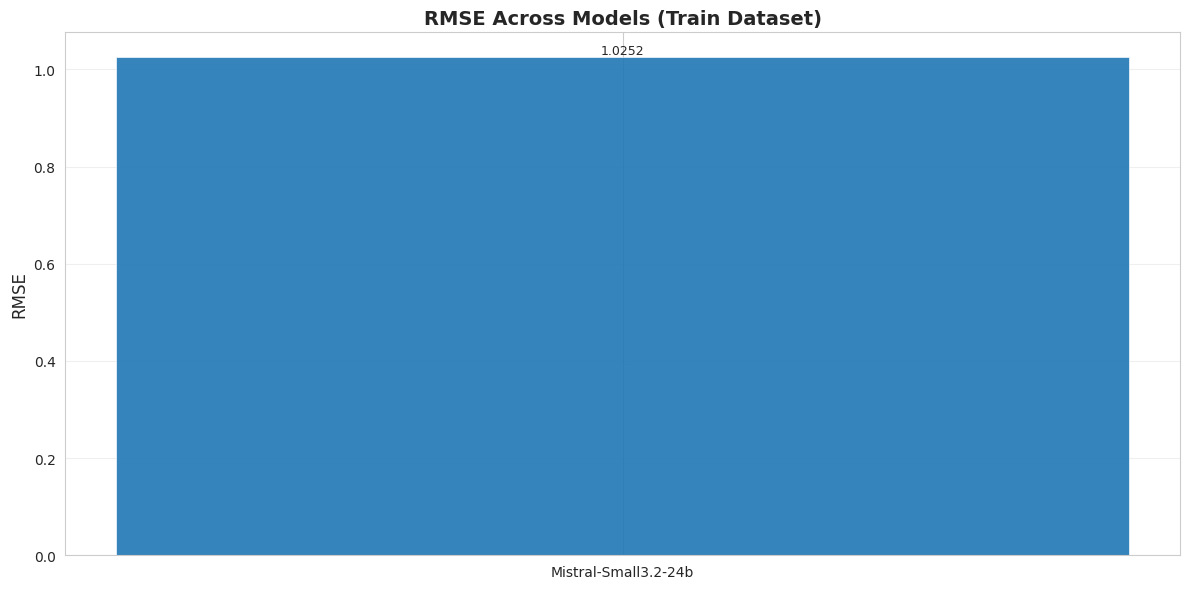

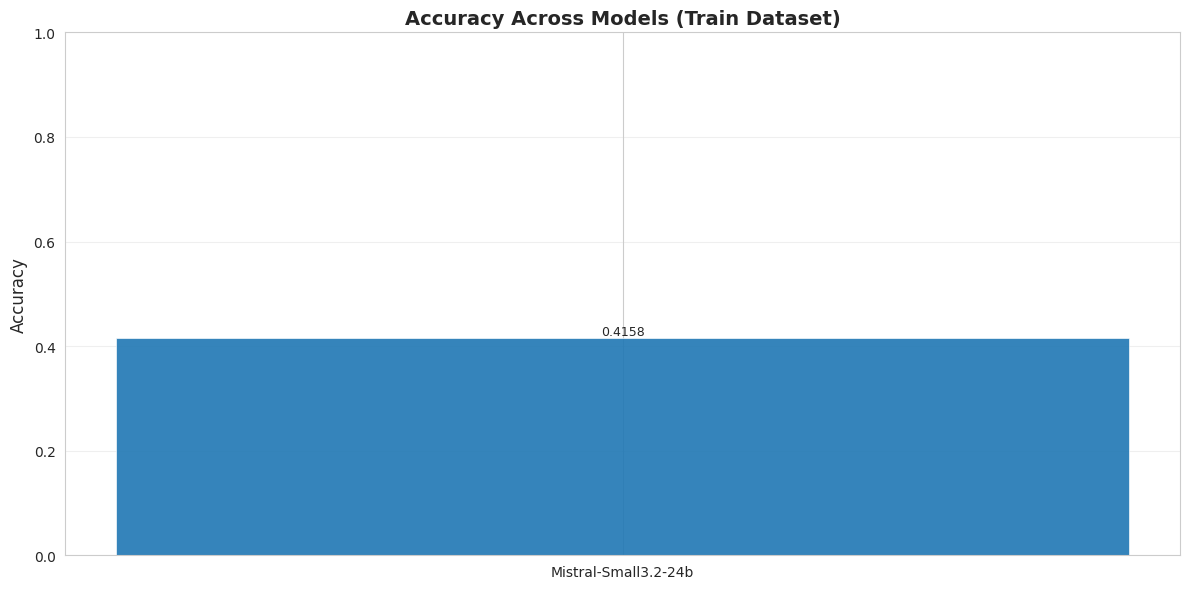

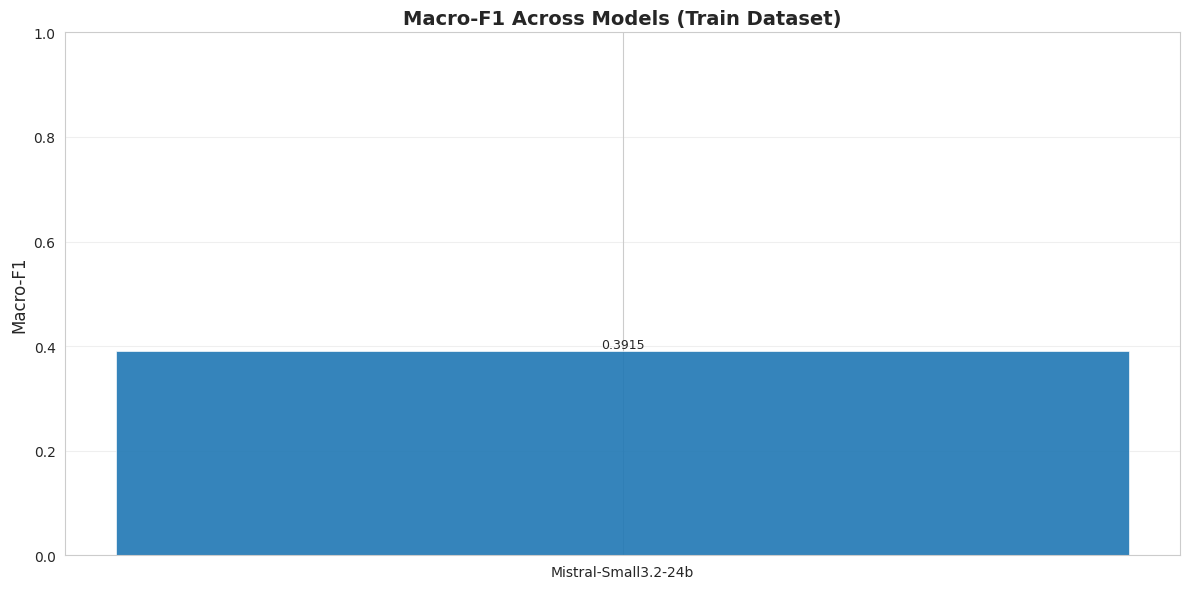

In [ ]:
if multiple_models:
    vis_all_models_plots(multiple_models, "train")

## Relaxed Class Mode (merge 0/1, 2/3, 4/5)

These evaluations recompute metrics and confusion matrices after collapsing labels into three classes.



TRAIN SET CONFUSION MATRIX


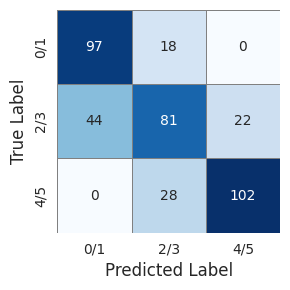


Confusion Matrix Statistics:
  Total predictions: 392
  Correct predictions (diagonal): 280
  Incorrect predictions (off-diagonal): 112
  Accuracy: 0.7143

Per-label statistics:
  Label 0: 97/115 correct (84.35%)
  Label 1: 81/147 correct (55.10%)
  Label 2: 102/130 correct (78.46%)


In [45]:
filtered_score_data_relaxed = [
    sd for sd in filtered_score_data if sd.config_id == SELECTED_CONFIG_IDX
]
if filtered_score_data_relaxed:
    sd_relaxed = filtered_score_data_relaxed[0]
    relaxed_conf_model = llm_metrics_to_core(
        predictions=to_int_0_5(sd_relaxed.train_scores)
        if sd_relaxed.train_scores is not None and sd_relaxed.train_scores.size > 0
        else None,
        labels=sd_relaxed.y_train
        if sd_relaxed.train_scores is not None and sd_relaxed.train_scores.size > 0
        else None,
        test_predictions=to_int_0_5(sd_relaxed.test_scores)
        if sd_relaxed.test_scores is not None and sd_relaxed.test_scores.size > 0
        else None,
        test_labels=sd_relaxed.y_test
        if sd_relaxed.test_scores is not None and sd_relaxed.test_scores.size > 0
        else None,
        model_name=sd_relaxed.model_name,
    )
    vis_specific_model_conf_matrices(
        relaxed_conf_model,
        show_proportional=False,
        show_title=False,
        class_mode="relaxed",
    )
else:
    print(f"No models found for configuration {SELECTED_CONFIG_IDX}")

In [ ]:
vis_all_models_plots(multiple_models, dataset="train", class_mode="relaxed")

In [46]:
model_names = [m.model for m in multiple_models]
model_groups, show_large_variants = get_llm_model_groups(model_names)
df_metrics_relaxed = vis_all_models_tables(
    multiple_models,
    ["Acc"],
    ["Train", "Test"],
    model_groups,
    show_large_variants,
    class_mode="relaxed",
)
latex_table_relaxed = format_metrics_for_latex(df_metrics_relaxed)
print(latex_table_relaxed)

,Model,Train Acc,Test Acc
0,Ministral3-14b,0.7143,
1,Gemma3-12b,0.6837,
2,Qwen3-14b,0.6607,
3,Mistral-Small3.2-24b,0.7041,


\begin{tabular}{rrr}
\toprule
\textbf{Model} & \textbf{Train Acc} & \textbf{Test Acc} \\
\midrule
Ministral3-14b & \textbf{0.7143} &  \\
Gemma3-12b & 0.6837 &  \\
Qwen3-14b & 0.6607 &  \\
Mistral-Small3.2-24b & 0.7041 &  \\
\bottomrule
\end{tabular}



/home/terra/Projects/vis-desc/modules/lab/src/evaluation/core.py:915: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '\textbf{0.7143}' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  


### Scale Comparison: Normal vs Relaxed

In [52]:
# Extract test set metrics for selected configuration
filtered_score_data_comparison = [
    sd for sd in filtered_score_data if sd.config_id == SELECTED_CONFIG_IDX
]

if filtered_score_data_comparison:
    sd_comparison = filtered_score_data_comparison[0]

    # Compute comparison table
    df_comparison, metrics = compute_scale_comparison_table(
        sd_comparison, to_int_0_5, llm_metrics_to_core
    )

    if df_comparison is not None:
        print(f"\nTest Set Metrics for {sd_comparison.model_name}:")
        print("=" * 50)
        print(df_comparison.to_string(index=False))
        print("\n")

        # LaTeX version
        latex_comparison = df_comparison.to_latex(
            index=False,
            escape=False,
            caption=f"Test Set Metrics Comparison: Normal vs Relaxed Scale ({sd_comparison.model_name})",
            label="tab:scale_comparison",
        )
        print(latex_comparison)
    else:
        print(f"No test set data available for {sd_comparison.model_name}.")
else:
    print(f"No models found for configuration {SELECTED_CONFIG_IDX}")

No test set data available for Ministral3-14b.
